In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


from pypfopt import EfficientFrontier, risk_models, expected_returns

In [2]:
# Setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)
FIGURES_PATH = '../reports/figures/'

try:
    daily_returns = pd.read_csv('../data/processed/daily_returns.csv', index_col='Date', parse_dates=True)
    print("Historical daily returns data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure 'daily_returns.csv' from Task 1 exists.")
    exit()

Historical daily returns data loaded successfully.


In [ ]:
# Setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
FIGURES_PATH = '../reports/figures/'

# Load Historical and Forecasted Data
try:
    # Historical daily returns for all assets (from Task 1)
    daily_returns = pd.read_csv('../data/processed/daily_returns.csv', index_col='Date', parse_dates=True)
    
    # Historical closing prices (to get the last price of TSLA)
    close_prices = pd.read_csv('../data/processed/close_prices.csv', index_col='Date', parse_dates=True)
    mean_forecast = np.load('../models/lstm_mean_forecast.npy') 

    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure all required data files from previous tasks exist.")
    exit()

Data loaded successfully.


In [3]:
# Define Backtesting Period 
backtest_start_date = '2024-08-01'
backtest_end_date = '2025-07-31'
backtest_returns = daily_returns.loc[backtest_start_date:backtest_end_date]

strategy_weights = {
    'TSLA': 0.99959,
    'BND': 0.0,
    'SPY': 0.00041
}

strategy_weights = pd.Series(strategy_weights)
benchmark_weights = {
    'TSLA': 0.0,
    'BND': 0.40,
    'SPY': 0.60
}
benchmark_weights = pd.Series(benchmark_weights)

print("Backtesting Period and Strategies Defined.")
print("\nYour Strategy Weights:")
print(strategy_weights)
print("\nBenchmark Weights:")
print(benchmark_weights)

Backtesting Period and Strategies Defined.

Your Strategy Weights:
TSLA    0.99959
BND     0.00000
SPY     0.00041
dtype: float64

Benchmark Weights:
TSLA    0.0
BND     0.4
SPY     0.6
dtype: float64


In [4]:
# Simulate the "Your Strategy" Portfolio
strategy_daily_returns = (backtest_returns * strategy_weights).sum(axis=1)
strategy_cumulative_returns = (1 + strategy_daily_returns).cumprod()

# Simulate the "Benchmark" Portfolio
benchmark_daily_returns = (backtest_returns * benchmark_weights).sum(axis=1)
benchmark_cumulative_returns = (1 + benchmark_daily_returns).cumprod()

Backtest plot saved to: ../reports/figures/06_backtest_performance.png


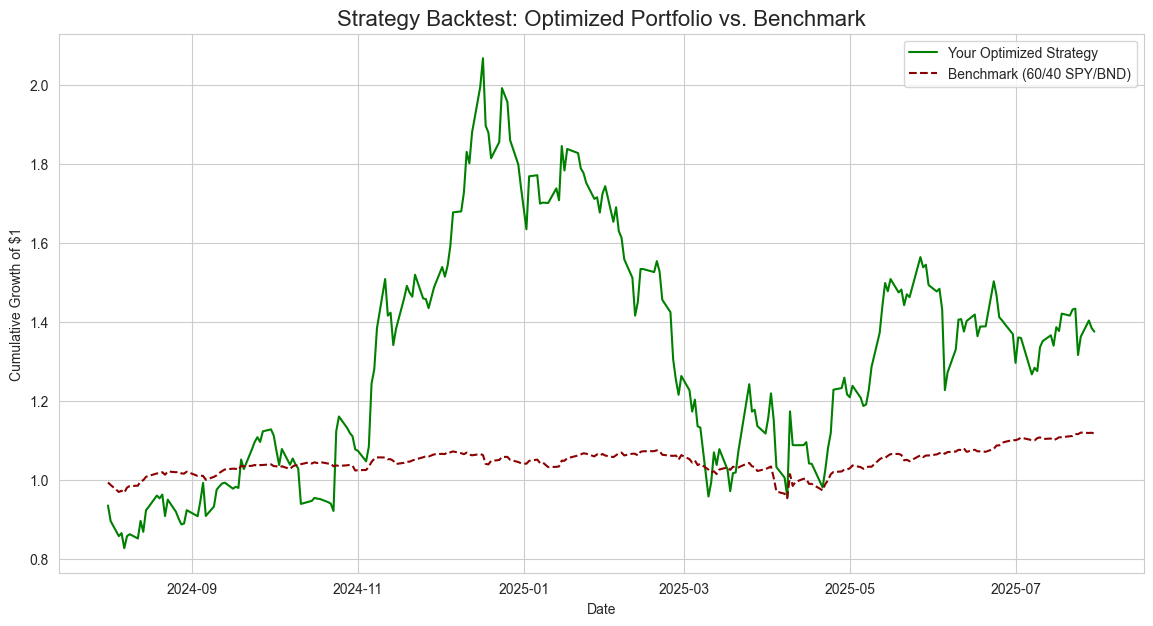

In [5]:
# Plot
plt.figure(figsize=(14, 7))
plt.plot(strategy_cumulative_returns.index, strategy_cumulative_returns, label='Your Optimized Strategy', color='green')
plt.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, label='Benchmark (60/40 SPY/BND)', color='darkred', linestyle='--')

plt.title('Strategy Backtest: Optimized Portfolio vs. Benchmark', fontsize=16)
plt.ylabel('Cumulative Growth of $1')
plt.xlabel('Date')
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig(os.path.join(FIGURES_PATH, '06_backtest_performance.png'), dpi=300)
print(f"Backtest plot saved to: {os.path.join(FIGURES_PATH, '06_backtest_performance.png')}")

plt.show()

In [6]:
# Helper function to calculate annualized Sharpe Ratio
def annualized_sharpe_ratio(returns, risk_free_rate=0.02):
    """Calculates the annualized Sharpe ratio for a returns series."""
    mean_daily_return = returns.mean()
    std_daily_return = returns.std()
    
    # Annualize
    annualized_return = mean_daily_return * 252
    annualized_volatility = std_daily_return * np.sqrt(252)
    
    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    return sharpe_ratio

# Metrics for Strategy 
strategy_total_return = (strategy_cumulative_returns.iloc[-1] - 1)
strategy_sharpe = annualized_sharpe_ratio(strategy_daily_returns)

# Metrics for Benchmark 
benchmark_total_return = (benchmark_cumulative_returns.iloc[-1] - 1)
benchmark_sharpe = annualized_sharpe_ratio(benchmark_daily_returns)

# Display Final Comparison
print("\n" + "="*50)
print("       BACKTESTING PERFORMANCE SUMMARY")
print("="*50)
print(f"Period: {backtest_start_date} to {backtest_end_date}\n")

print(f"{'Metric':<25} {'Your Strategy':<20} {'Benchmark (60/40)':<20}")
print("-"*65)
print(f"{'Total Return':<25} {strategy_total_return:,.2%} {benchmark_total_return:,.2%}")
print(f"{'Annualized Sharpe Ratio':<25} {strategy_sharpe:.2f} {benchmark_sharpe:.2f}")
print("="*50)


       BACKTESTING PERFORMANCE SUMMARY
Period: 2024-08-01 to 2025-07-31

Metric                    Your Strategy        Benchmark (60/40)   
-----------------------------------------------------------------
Total Return              37.48% 11.68%
Annualized Sharpe Ratio   0.77 0.80
